<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>02. EDA para C_SEV</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---


## 2.0 Introducción

En este notebook nos serviremos del análisis realizado en el EDA para poder preparar los datos y utilizarlos para elaborar un modelo que nos permita clasificar según la posibilidad de fallecimientos dado un accidente.

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 2.0.1 Estructura

## Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import nbconvert

%matplotlib inline

## Scripts

In [2]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import eda_tools

## 2.1 Carga de datos
Ahora realizamos la carga de los datos originales que analizamos en el EDA.

In [3]:
accidents_df = csv_tools.csv_import(origin = '../data/NCDB_1999_to_2014.csv')

Reading file...
Reading ended.


Ahora procederemos a modificarlos. Recordamos que el modelo propuesto busca tener información sobre un accidente y predecir la posible mortalidad del mismo. Para ello, como los datos se encuentran enfocados a definir la información de una persona en un accidente, y tenemos información para varias personas en el mismo accidente, debemos agregar los datos principalmente.

## 2.2 Preprocesado del dataset
Vamos a modificar el dataset original para que cumpla los requisitos necesario para ser utilizados en la elaboración de un modelo de clasificación de accidentes mortales o no. 

### 2.2.1 Eliminación de filas I

Lo primero que vamos a eliminar son las filas repetidas que observamos en el EDA general. Hacer esto primero nos permitirá eliminar filas y agilizar las tareas en el resto de código. 

In [4]:
accidents_df.drop_duplicates(keep='last', inplace=True)

Ahora procedemos a eliminar las filas con valores anómalos. En este caso hablamos de los vehículos del año 2015 que tuvieron un accidente en 2014. Estas filas carecen de sentido.

In [5]:
accidents_df = accidents_df.drop(accidents_df[accidents_df['V_YEAR'] == '2015'].index, axis=0)

Al analizar los datos pudimos observar como existian valores especiales. Para este modelo nos centramos en los valores ```N```, estos estaban presentes en las variables referentes a personas, las cuales eran valores *no aplicables* al no tratarse de personas involucradas en un accidente. En la agregación, no solo buscamos obtener una fila por accidente, sino que también crear una nueva variable como el total de personas involucradas en un accidente. Debemos eliminar los vehículos aparcados pues no son personas que puedan fallecer al verse en vueltas en un accidente.

In [6]:
per_columns = [['P_SEX', 'N'], ['P_AGE', 'NN'], ['P_PSN', 'NN'], 
               ['P_ISEV', 'N'], ['P_SAFE', 'NN'], ['P_USER', 'N']]

for col in per_columns:
    accidents_df = accidents_df.drop(accidents_df[accidents_df[col[0]] == col[1]].index, axis=0)

Verificamos que están fuera del dataset.

In [7]:
# Verifico que se han eliminado
per_columns = ['P_SEX', 'P_AGE', 'P_PSN', 
               'P_ISEV', 'P_SAFE', 'P_USER']
eda_tools.special_values_summary(df = accidents_df[per_columns], vals = [['N', 'NN']])

,column_name,N,N%,total,total%
0,P_SEX,0,[0.0],0,0.0
1,P_AGE,0,[0.0],0,0.0
2,P_PSN,0,[0.0],0,0.0
3,P_ISEV,0,[0.0],0,0.0
4,P_SAFE,0,[0.0],0,0.0
5,P_USER,0,[0.0],0,0.0


Finalmente, vamos a analizar los valores ```U```. Estos indican información desconocida, en el EDA analizamos esto por columnas, sin embargo, no hicimos un análisis exaustivo por filas. Nuestro objetivo es buscar aquellas filas con un elevado porcentaje de información nula, lo que las hace poco útiles en el dataset.

A modo de *treshold* establecemos un 80% como valor límite. Teniendo este dataset un total de 20 variables con posibles nulos, consideramos que el hecho de tener 16 variables con valor U descarta a esa fila como útil para el conjunto de datos.

<div style='color:blue'> 
   
rows = list()
values = ['U', 'UU', 'UUUU']
cat_columns = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 
               'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 
               'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 
               'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 
               'P_PSN', 'P_ISEV', 'P_SAFE','P_USER']

for index, row in accidents_df[cat_columns].iterrows():
    counter = 0
    for col in row.index:
        if row[col] in values:
            counter += 1
    
    if (counter / len(row.index)) >= 0.7:
        rows.append(index)
</div>

### 2.2.2 Agregación
Ahora ya podemos agregar las filas del dataset por accidente. Además realizaremos un conteo de filas de cada agregación, es decir, el número de personas involucradas en el accidente.

In [8]:
# Agregación final
acc_columns = ['C_YEAR', 'C_MNTH', 'C_WDAY', 
               'C_HOUR', 'C_SEV', 'C_VEHS', 
               'C_CONF', 'C_RCFG', 'C_WTHR', 
               'C_RSUR', 'C_RALN', 'C_TRAF']

sev_df = accidents_df.groupby(acc_columns).agg(C_PERS=('P_USER', 'count')).reset_index()
sev_df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS
0,1999,01,1,00,2,01,01,01,1,4,1,18,1
1,1999,01,1,00,2,01,01,01,1,5,1,18,1
2,1999,01,1,00,2,01,01,01,2,1,1,18,1
3,1999,01,1,00,2,01,01,01,6,3,2,18,2
4,1999,01,1,00,2,01,01,UU,1,2,3,18,1


### 2.2.3 Reducción de categorías

A raíz del EDA general, hemos podido observar ciertos aspectos de la distribucion de los datos en las categorías de las variables que nos permiten reducir sus valores, de forma que sea más sencillo manejarlas en el modelo.

En concreto realizaremos las siguiente reducciones:

**Variable ```C_MNTH```**:

Visualmente en el EDA pudimos observar que los accidentes mortales se concentraban entorno a unos meses en concreto: Julio, y Agosto, si bien los accidentes mortales continuan destacando en los meses posteriores hasta Navidad. 

### 2.2.4 Guardado del dataset final

In [17]:
sev_df.to_csv("../data/sev_df.csv", index = False)

## 2.3 Análisis
A continuación repetimos un pequeño análisis con le objetivo de valorar el resultado de las modificaciones y el dataset resultante.

### 2.3.1 Variable objetivo

In [16]:
eda_tools.classes_overview(df = sev_df, obj_val = 'C_SEV')

,index,percentaje,C_SEV
0,2,98.059561,1756284
1,1,1.940439,34754


### 2.3.2 Valores especiales

In [14]:
# Valores especiales
Q = ['Q', 'QQ', 'QQQQ']
U = ['U', 'UU', 'UUUU']
vals_hists = [Q, U]

eda_tools.special_values_summary(df=sev_df, vals=vals_hists)

,column_name,Q,Q%,U,U%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],94,[0.005],94,0.0
2,C_WDAY,0,[0.0],492,[0.027],492,0.0
3,C_HOUR,0,[0.0],23067,[1.288],23067,1.3
4,C_SEV,0,[0.0],0,[0.0],0,0.0
5,C_VEHS,0,[0.0],139,[0.008],139,0.0
6,C_CONF,105900,[5.913],65310,[3.646],171210,9.6
7,C_RCFG,60231,[3.363],177330,[9.901],237561,13.3
8,C_WTHR,5327,[0.297],33393,[1.864],38720,2.2
9,C_RSUR,63498,[3.545],29054,[1.622],92552,5.2


### 2.3.3 Variables numéricas

<AxesSubplot:>

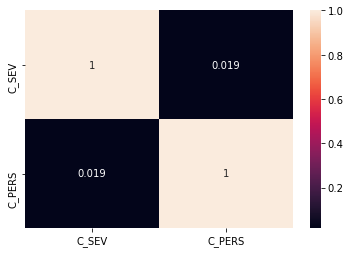

In [10]:
sns.heatmap(sev_df[['C_SEV', 'C_PERS']].corr(), annot=True)

In [11]:
sev_df['C_PERS'].describe().apply(lambda x: '%.5f' % x)

count    1791038.00000
mean           2.93026
std            2.57987
min            1.00000
25%            1.00000
50%            2.00000
75%            4.00000
max          123.00000
Name: C_PERS, dtype: object

<AxesSubplot:>

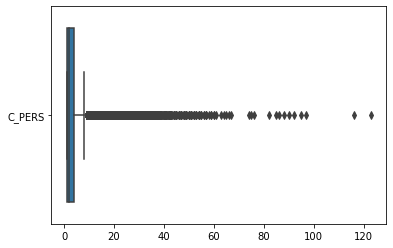

In [12]:
sns.boxplot(data=sev_df[['C_PERS']], orient="h")

### 2.3.4 Variables categóricas

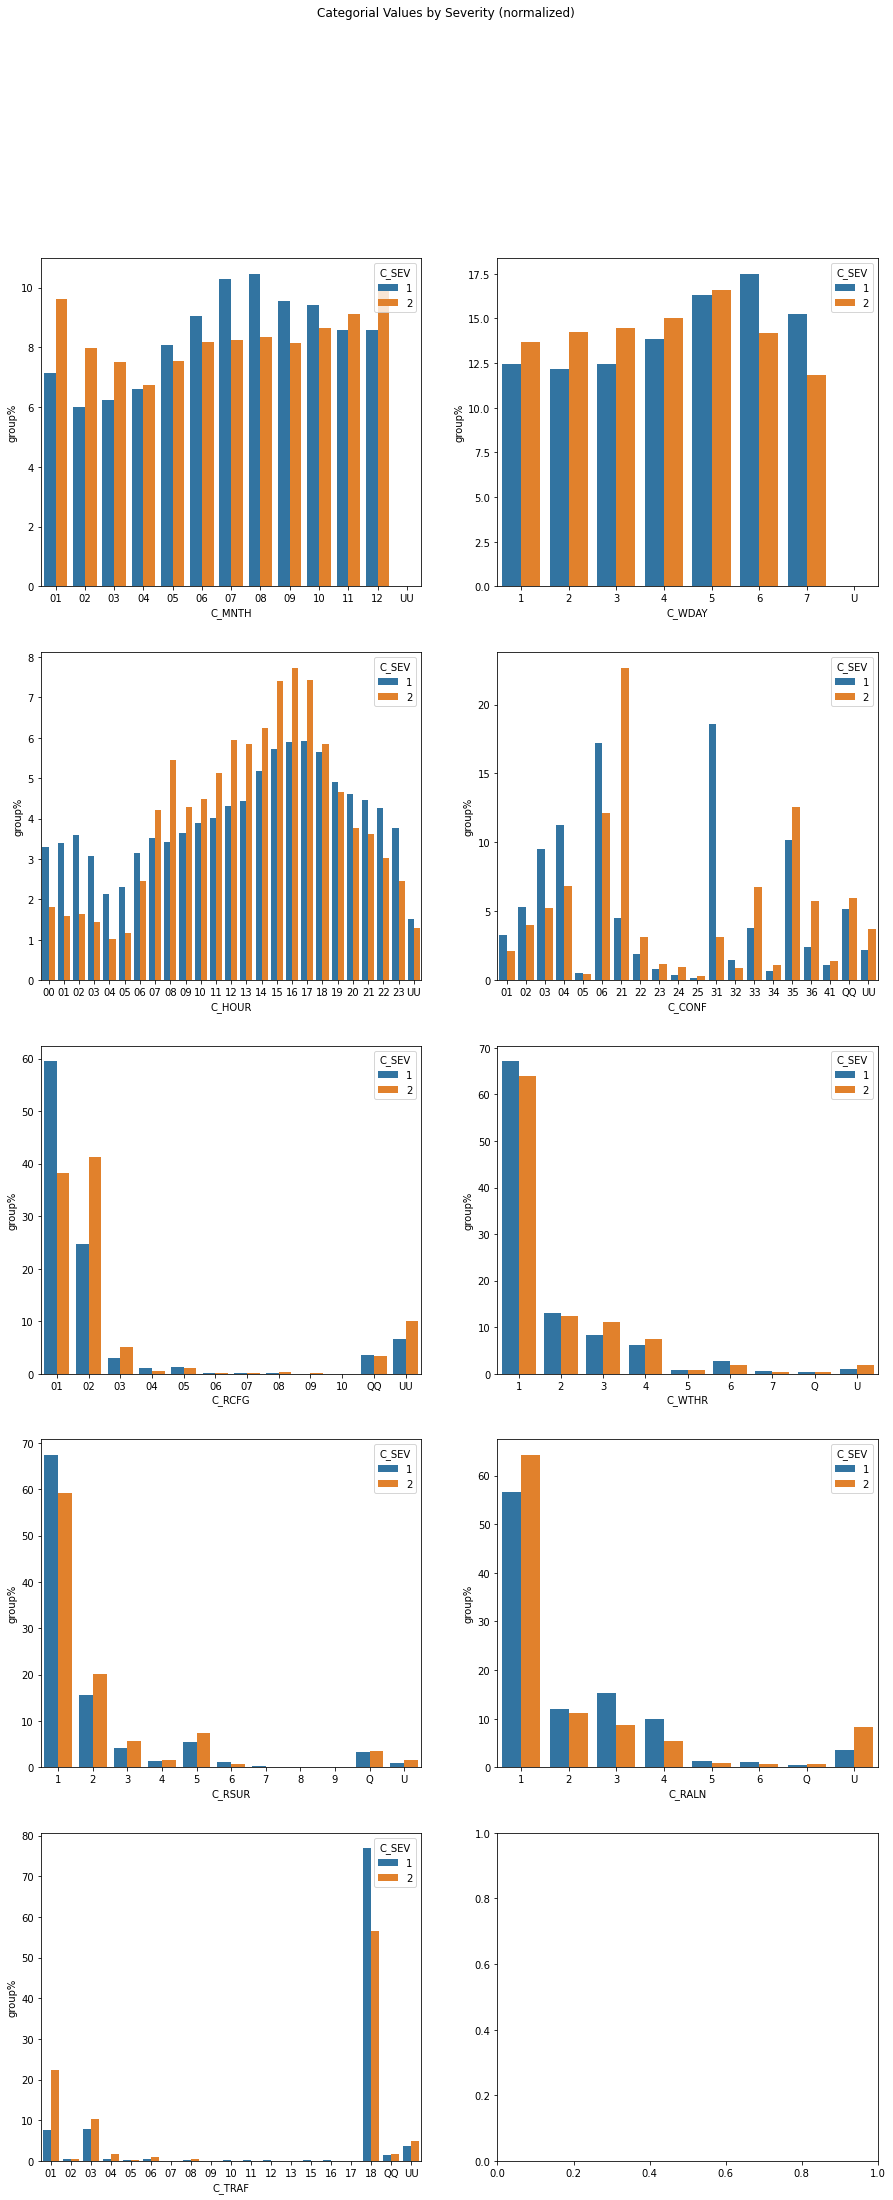

In [15]:
categorical = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF', 
               'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 
               'C_TRAF']

fig, axes = plt.subplots(5, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0
j = 0
for cat in categorical:
    temp = eda_tools.norm_category(df = sev_df, obj_val = 'C_SEV', cat_val = cat)
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'C_SEV', ax = axes[i,j]);
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

## 2.4 Conclusiones

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 